In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data loading

## Loading data into RAM in expected format and visualizing

In [2]:
from mnist import *
from pprint import pprint
random.seed(12345)

dataset = load_dataset()
print dataset.keys()

Couldn't import dot_parser, loading of dot files will not be possible.
['X_test', 'X_train', 'y_train', 'X_valid', 'y_valid', 'y_test']


Using gpu device 0: GeForce GT 750M


float32 float32
(10000, 1, 28, 28) (10000, 10)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


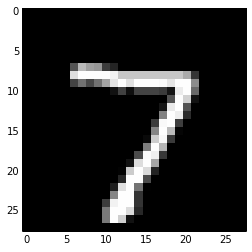

In [3]:
print dataset['X_test'].dtype, dataset['y_test'].dtype
print dataset['X_test'].shape, dataset['y_test'].shape
print dataset['y_test'][0]
imshow(dataset['X_test'][0].reshape(28,28), cmap=cm.gray, interpolation='nearest')

## Breaking data into batches in callable form

In [4]:
# define generators
# make a generator to yield a batch of data for training/validating
class iterate_minibatches():
    def __init__(self, dataset, batchsize, partition='train'):
        self.dataset = dataset
        self.batchsize = batchsize
        self.partition = partition

    def __call__(self):
        inputs = self.dataset['X_'+self.partition]
        targets = self.dataset['y_'+self.partition]
        for start_idx in range(0, len(inputs) - self.batchsize + 1, self.batchsize):
            excerpt = slice(start_idx, start_idx + self.batchsize)
            batchdata = dict(
                X=inputs[excerpt],
                y=targets[excerpt]
            )
            yield batchdata

In [5]:
# make a train batch iterator and get a batch from it
trainbatchit = iterate_minibatches(dataset, BATCHSIZE, 'train')
it = trainbatchit()
batch = it.next()
print batch.keys()
print batch['X'].shape, batch['X'].dtype

# Note: 'X' and 'y' are the inputs and labels that will be bound to model layers

['y', 'X']
(500, 1, 28, 28) float32


# Model building

In [6]:
# Define an XNN model that is a container around layer graphs
m = Model("MLP")

pprint(m.to_dict())

{'eval_outputs': OrderedDict(),
 'inputs': OrderedDict(),
 'layers': [],
 'name': 'MLP',
 'outputs': OrderedDict()}


In [7]:
# This creates an MLP of two hidden layers of 800 units each, followed by
# a softmax output layer of 10 units. It applies 20% dropout to the input
# data and 50% dropout to the hidden layers.

# Input layer, specifying the expected input shape of the network
# (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
# linking it to the given Theano variable `input_var`, if any:

l_in = m.add_layer(InputLayer((None, 1, 28, 28)))

# Apply 20% dropout to the input data:
l_in_drop = m.make_dropout_layer(l_in, p=0.2)

# Add a stack of fully-connected layers of 800 units each with dropout
l_stacktop = m.make_dense_drop_stack(l_in_drop, [800, 800], drop_p_list=[.5, .5])

# Finally, we'll add the fully-connected output layer, of 10 softmax units:
l_out = m.add_layer(DenseLayer(l_stacktop, num_units=10, nonlinearity=softmax), "l_out")

pprint(m.to_dict())

{'eval_outputs': OrderedDict(),
 'inputs': OrderedDict(),
 'layers': [{'layer_type': 'InputLayer',
             'name': 'InputLayer_0',
             'output_shape': (None, 1, 28, 28),
             'shape': (None, 1, 28, 28)},
            {'incoming': 'InputLayer_0',
             'input_shape': (None, 1, 28, 28),
             'layer_type': 'DropoutLayer',
             'name': 'DropoutLayer_0',
             'output_shape': (None, 1, 28, 28),
             'p': 0.2,
             'rescale': True},
            {'incoming': 'DropoutLayer_0',
             'input_shape': (None, 1, 28, 28),
             'layer_type': 'DenseLayer',
             'name': 'DenseLayer_0',
             'nonlinearity': 'rectify',
             'num_units': 800,
             'output_shape': (None, 800)},
            {'incoming': 'DenseLayer_0',
             'input_shape': (None, 800),
             'layer_type': 'DropoutLayer',
             'name': 'DropoutLayer_1',
             'output_shape': (None, 800),
             '

In [8]:
m.bind_input(l_in, 'X')
m.bind_output(l_out, categorical_crossentropy, 'y')

pprint(m.to_dict())

{'eval_outputs': OrderedDict(),
 'inputs': OrderedDict([('X', ['InputLayer_0'])]),
 'layers': [{'layer_type': 'InputLayer',
             'name': 'InputLayer_0',
             'output_shape': (None, 1, 28, 28),
             'shape': (None, 1, 28, 28)},
            {'incoming': 'InputLayer_0',
             'input_shape': (None, 1, 28, 28),
             'layer_type': 'DropoutLayer',
             'name': 'DropoutLayer_0',
             'output_shape': (None, 1, 28, 28),
             'p': 0.2,
             'rescale': True},
            {'incoming': 'DropoutLayer_0',
             'input_shape': (None, 1, 28, 28),
             'layer_type': 'DenseLayer',
             'name': 'DenseLayer_0',
             'nonlinearity': 'rectify',
             'num_units': 800,
             'output_shape': (None, 800)},
            {'incoming': 'DenseLayer_0',
             'input_shape': (None, 800),
             'layer_type': 'DropoutLayer',
             'name': 'DropoutLayer_1',
             'output_shape': (N

In [9]:
# show the model graph
modelgraphimg = xnn.utils.draw_to_file(m, '/tmp/modelgraph.png')
modelgraphimg.show()

## Predict outputs before training

In [10]:
outs = m.predict(batch)
print outs.keys()
print outs['l_out'].shape
print outs['l_out'][0]

['DenseLayer_1', 'DenseLayer_0', 'InputLayer_0', 'DropoutLayer_2', 'DropoutLayer_1', 'DropoutLayer_0', 'l_out']
(500, 10)
[ 0.05717565  0.11806224  0.11426906  0.12122438  0.06255974  0.13076603
  0.08849301  0.10443016  0.10315739  0.09986235]


## Saving and loading model

In [11]:
m.save_model('/tmp/model.pkl')
m2 = Model("loaded model")
m2.load_model('/tmp/model.pkl')
outs2 = m2.predict(batch)
print outs['l_out'][0] == outs2['l_out'][0]

[ True  True  True  True  True  True  True  True  True  True]


# Trainer

In [12]:
# first set up global parameters for nesterov momentum
global_update_settings = ParamUpdateSettings(
    update=nesterov_momentum, learning_rate=0.25, momentum=0.9)

# instantiate a trainer
trainer = Trainer(m, global_update_settings)
pprint(trainer.to_dict())

{'global_update_settings': {'settings': {'learning_rate': 0.25,
                                         'momentum': 0.9},
                            'update': 'nesterov_momentum'},
 'layer_updates': {},
 'model': 'MLP',
 'regularizations': {}}


## Run some training steps on a batch and modify updates

In [13]:
set_printoptions(precision=3, suppress=True)
print batch['y'][0]
for i in range(5):
    trainer.train_step(batch)
    outs = m.predict(batch)
    print outs['l_out'][0]

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.216  0.078  0.026  0.106  0.099  0.08   0.074  0.057  0.1    0.163]
[ 0.025  0.097  0.056  0.284  0.049  0.118  0.076  0.103  0.104  0.087]
[ 0.08   0.062  0.047  0.242  0.044  0.127  0.065  0.084  0.123  0.127]
[ 0.042  0.026  0.015  0.598  0.012  0.097  0.022  0.052  0.086  0.05 ]
[ 0.016  0.016  0.014  0.458  0.007  0.217  0.02   0.029  0.154  0.068]


In [14]:
# decrease learning rate and continue training
trainer.bind_global_update(ParamUpdateSettings(learning_rate=0.1))
for i in range(10):
    trainer.train_step(batch)
    outs = m.predict(batch)
    print outs['l_out'][0]

[ 0.006  0.003  0.004  0.647  0.001  0.224  0.004  0.013  0.076  0.021]
[ 0.003  0.001  0.001  0.73   0.     0.208  0.001  0.003  0.046  0.006]
[ 0.002  0.     0.001  0.727  0.     0.237  0.     0.001  0.029  0.003]
[ 0.002  0.     0.001  0.782  0.     0.173  0.     0.001  0.04   0.001]
[ 0.001  0.     0.     0.794  0.     0.194  0.     0.     0.011  0.   ]
[ 0.     0.     0.     0.899  0.     0.095  0.     0.     0.006  0.   ]
[ 0.     0.     0.     0.832  0.     0.16   0.     0.     0.008  0.   ]
[ 0.     0.     0.     0.833  0.     0.143  0.     0.     0.024  0.   ]
[ 0.     0.     0.     0.688  0.     0.301  0.     0.     0.011  0.   ]
[ 0.     0.     0.     0.482  0.     0.511  0.     0.     0.007  0.   ]


In [15]:
# add l2-regularization with weight .001 to weights to all layers
trainer.bind_regularization(xnn.regularization.l2, .001)

for i in range(5):
    trainer.train_step(batch)
    outs = m.predict(batch)
    print outs['l_out'][0]

[ 0.     0.     0.     0.807  0.     0.185  0.     0.     0.008  0.   ]
[ 0.001  0.     0.     0.597  0.     0.392  0.     0.     0.01   0.   ]
[ 0.     0.     0.     0.279  0.     0.713  0.     0.     0.007  0.   ]
[ 0.001  0.     0.     0.27   0.     0.722  0.     0.     0.006  0.   ]
[ 0.001  0.     0.001  0.331  0.     0.655  0.     0.     0.011  0.   ]


# Training loop

In [16]:
# let's start the batch iteration from scratch and re-initialize the model
trainbatchit = iterate_minibatches(dataset, BATCHSIZE, 'train')
validbatchit = iterate_minibatches(dataset, BATCHSIZE, 'valid')

# use a convenience function defined in mnist.py to build the same mlp as above 
m = build_mlp()
trainer.set_model(m)

# define some metrics to keep track of performance
metrics = [
    ('l_out', Metric(computeCategoricalCrossentropy, "y", aggregation_type="mean"), 'min'),
    ('l_out', Metric(computeOneHotAccuracy, "y", aggregation_type="none"), 'max')
]

# create a training loop
loop = Loop(trainer, trainbatchit, validbatchit, metrics, plotmetricmean=False)

# iterate through 3 epochs of training on all data
loop(3)

Epoch 0 / 2 -- 3.87 seconds
Expected Finish: Wed, 12:17:34 PM
----------
Training total cost                                               :   2.0118 (best 2.0118 at epoch 0)
----------
Categorical Crossentropy                      l_out               :   0.2853 (best 0.2853 at epoch 0)
Percent Correct                               l_out               :   0.9200 (best 0.9200 at epoch 0)
Epoch 1 / 2 -- 2.13 seconds
Expected Finish: Wed, 12:17:31 PM
----------
Training total cost                                               :   1.2873 (best 1.2873 at epoch 1)
----------
Categorical Crossentropy                      l_out               :   0.2105 (best 0.2105 at epoch 1)
Percent Correct                               l_out               :   0.9400 (best 0.9400 at epoch 1)
Epoch 2 / 2 -- 2.19 seconds
Expected Finish: Wed, 12:17:30 PM
----------
Training total cost                                               :   0.9448 (best 0.9448 at epoch 2)
----------
Categorical Crossentropy          

# Experiment

In [17]:
from xnn.experiments import *
# make an experiment condition class to store default variable values
class _Condition(ExperimentCondition):
    def __init__(self):
        self.numhid = 100
        self.hiddropout = .5

# add an experiment with a numhid factor testing several levels
expt = Experiment("numhid experiment", _Condition())
expt.add_factor("numhid", [100, 400, 800])
expt.add_factor("hiddropout", [0., .1, .25, .5])

pprint(expt.to_dict())

print '\nnum conditions:', expt.get_num_conditions()
print 'conditions:'
pprint(expt.get_all_conditions_changes())


{'default_condition': {'hiddropout': 0.5, 'numhid': 100},
 'factors': {'hiddropout': [0.0, 0.1, 0.25, 0.5], 'numhid': [100, 400, 800]}}

num conditions: 12
conditions:
{0: {'hiddropout': 0.0, 'numhid': 100},
 1: {'hiddropout': 0.1, 'numhid': 100},
 2: {'hiddropout': 0.25, 'numhid': 100},
 3: {'hiddropout': 0.5, 'numhid': 100},
 4: {'hiddropout': 0.0, 'numhid': 400},
 5: {'hiddropout': 0.1, 'numhid': 400},
 6: {'hiddropout': 0.25, 'numhid': 400},
 7: {'hiddropout': 0.5, 'numhid': 400},
 8: {'hiddropout': 0.0, 'numhid': 800},
 9: {'hiddropout': 0.1, 'numhid': 800},
 10: {'hiddropout': 0.25, 'numhid': 800},
 11: {'hiddropout': 0.5, 'numhid': 800}}


In [18]:
# iterate over all conditions
for cond in expt.get_conditions_iterator():
    pprint(cond.to_dict())


{'hiddropout': 0.0, 'numhid': 100}
{'hiddropout': 0.1, 'numhid': 100}
{'hiddropout': 0.25, 'numhid': 100}
{'hiddropout': 0.5, 'numhid': 100}
{'hiddropout': 0.0, 'numhid': 400}
{'hiddropout': 0.1, 'numhid': 400}
{'hiddropout': 0.25, 'numhid': 400}
{'hiddropout': 0.5, 'numhid': 400}
{'hiddropout': 0.0, 'numhid': 800}
{'hiddropout': 0.1, 'numhid': 800}
{'hiddropout': 0.25, 'numhid': 800}
{'hiddropout': 0.5, 'numhid': 800}


In [19]:
# iterate over numhid, holding hiddropout fixed at 0.5
for cond in expt.get_conditions_slice_iterator(['numhid'],{'hiddropout':0.5}):
    pprint(cond.to_dict())

{'hiddropout': ('hiddropout', 0.5), 'numhid': 100}
{'hiddropout': ('hiddropout', 0.5), 'numhid': 400}
{'hiddropout': ('hiddropout', 0.5), 'numhid': 800}
